In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install POT

In [3]:
from CausalBenchmark.parameters import build_parameters_from_specification, DEFAULT_PARAMETER_PATH, build_parameters_from_metric_levels
from CausalBenchmark.constants import Constants
from CausalBenchmark.data_generation import DataGeneratingProcessWrapper
from CausalBenchmark.utilities import generate_random_covariates, normalize_covariate_data
from CausalBenchmark.data_metrics import calculate_data_metrics

In [4]:
from collections import defaultdict
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
covar_data = generate_random_covariates(n_covars = 12)
covar_data = normalize_covariate_data(covar_data)

In [ ]:
dgp_params = build_parameters_from_specification(DEFAULT_PARAMETER_PATH)
dgp_params.POTENTIAL_CONFOUNDER_SELECTION_PROBABILITY= 0.99
dgp_params.ACTUAL_CONFOUNDER_ALIGNMENT=0.99
dgp_params.TREATMENT_EFFECT_HETEROGENEITY = 0
dgp_params.OUTCOME_NOISE_TAIL_THICKNESS = 250

In [ ]:
dgp_wrapper = DataGeneratingProcessWrapper(
    parameters=dgp_params, source_covariate_data=covar_data)

dgp_wrapper.sample_dgp()

observed_covariate_data, observed_outcome_data, oracle_covariate_data, oracle_outcome_data = dgp_wrapper.generate_data()

In [ ]:
observed_outcome_data.head()
oracle_outcome_data.join(oracle_covariate_data).head()
observed_outcome_data.join(observed_covariate_data).head()
oracle_outcome_data.head()

## Metrics

In [8]:
def run(dgp_params, observation_spec,
        n_trials=10, n_covars=20, n_observations=250,
        verbose=False):
    results = defaultdict(lambda: defaultdict(list))
    for i in range(n_trials):
        if verbose:
            clear_output()
            print("Trials run:", i+1)
        results
        covar_data = generate_random_covariates(n_covars, n_observations)
        covar_data = normalize_covariate_data(covar_data)

        dgp_wrapper = DataGeneratingProcessWrapper(
            parameters=dgp_params, source_covariate_data=covar_data)
        dgp_wrapper.sample_dgp()

        observed_covariate_data, observed_outcome_data, oracle_covariate_data, oracle_outcome_data = dgp_wrapper.generate_data()
        metrics = calculate_data_metrics(
            observed_covariate_data, observed_outcome_data,
            oracle_covariate_data, oracle_outcome_data,
            observation_spec=observation_spec)
        
        for metric, measures in observation_spec.items():
            for measure in measures:
                res = metrics[metric][measure]
                results[metric][measure].append(res)
    
    if verbose:
        for metric, measures in results.items():
            for measure, result_data in measures.items():
                print(f"{metric} {measure}:")
                print("min", round(np.min(result_data), 3), end=" ")
                print("mean:", round(np.mean(result_data), 3), end=" ")
                print("max", round(np.max(result_data), 3))
                print("-------------\n\n")
        
    return results

In [9]:
metrics_and_measures = {
    Constants.MetricNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_obs, Y0)",
        "Lin r2(X_obs, TE)"
    ],
    Constants.MetricNames.TREATMENT_NONLINEARITY: [
        "Lin r2(X_obs, Treat Logit)"
    ],
    Constants.MetricNames.PERCENT_TREATED: [
        "Percent(T==1)"
    ],
    Constants.MetricNames.OVERLAP: [
        "NN dist X_obs: T=1<->T=0",
        "NN dist X_true: T=1<->T=0"
    ],
    Constants.MetricNames.BALANCE: [
        "Mean dist X_true: T=1<->T=0",
        "Wass dist X_true: T=1<->T=0",
        "Wass dist X_obs: T=1<->T=0"
    ],
    Constants.MetricNames.ALIGNMENT: [
        "Lin r2(Y, Treat Logit)",
        "Lin r2(Y0, Treat Logit)"
    ],
    Constants.MetricNames.TE_HETEROGENEITY: [
        "std(TE)/std(Y)"
    ]
}

levels = [
    Constants.MetricLevels.LOW,
    Constants.MetricLevels.MEDIUM,
    Constants.MetricLevels.HIGH,
]

results = defaultdict(lambda: defaultdict(dict))
max_measure_count = 0
for metric, measures in metrics_and_measures.items():
    print(f"\nRunning for {metric}. Level: ", end=" ")
    if len(measures) > max_measure_count:
        max_measure_count = len(measures)
    
    # Construct observation list of measures.
    observation_list = { metric: measures }
    
    # Run trials at all levels of metric.
    for level in levels:
        print(level, end=" ")
        dgp_params = build_parameters_from_metric_levels({
            metric: level
        })

        res = run(dgp_params, observation_list,
                  n_trials=20, n_covars=10)
        for measure, values in res[metric].items():
            results[metric][measure][level] = values


Running for OUTCOME_NONLINEARITY. Level:  LOW MEDIUM HIGH 
Running for TREATMENT_NONLINEARITY. Level:  LOW MEDIUM HIGH 
Running for PERCENT_TREATED. Level:  LOW MEDIUM HIGH 
Running for OVERLAP. Level:  LOW MEDIUM HIGH 
Running for BALANCE. Level:  LOW MEDIUM HIGH 
Running for ALIGNMENT. Level:  LOW MEDIUM HIGH 
Running for TE_HETEROGENEITY. Level:  LOW MEDIUM HIGH 

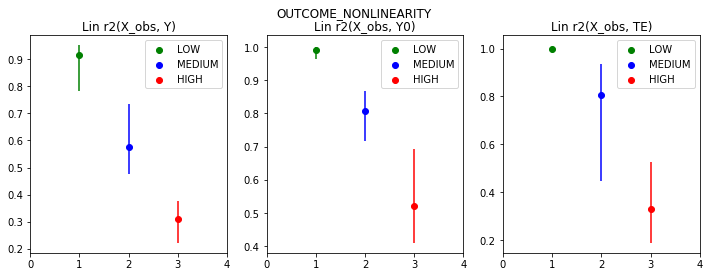

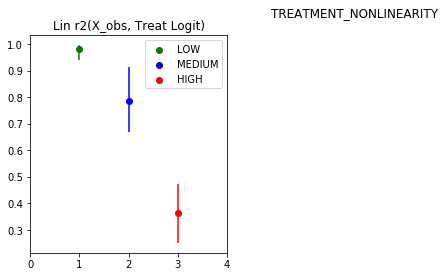

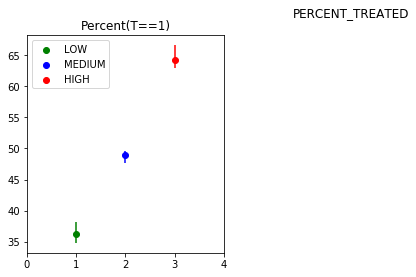

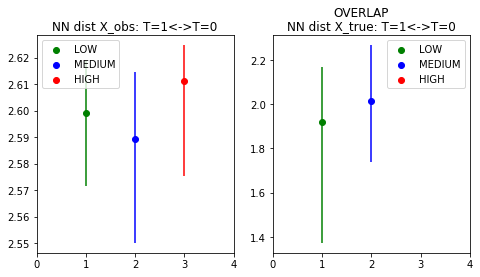

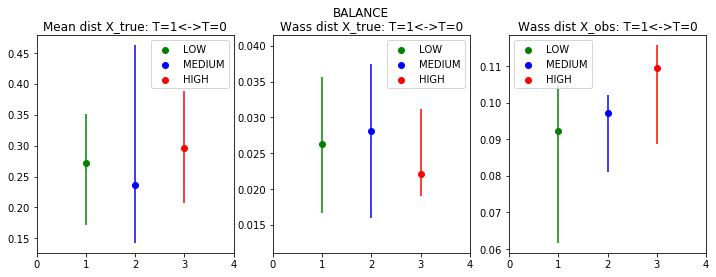

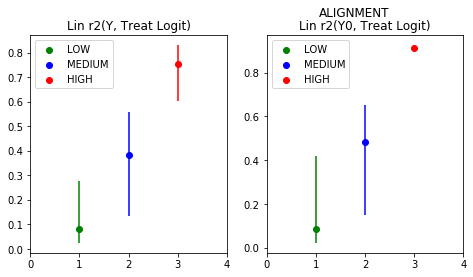

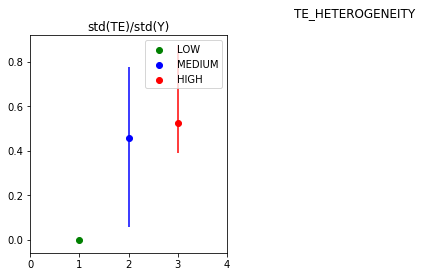

In [10]:
level_colors = ["g", "b", "r"]
for metric, measures in results.items():
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"{metric}")
    plt.tight_layout()
    
    for measure_num, (measure_name, measure_values) in enumerate(measures.items()):
        plt.subplot(1, max_measure_count, 1 + measure_num)
        plt.title(f"{measure_name}")
        for level_num, level in enumerate(levels):
            level_values = measure_values[level]
            
            # Find quartile values in data
            quartiles = np.percentile(
                level_values,
                [25, 50, 75],
                interpolation = 'midpoint')
            
            # Prepare plotting data
            x = level_num+1
            y = quartiles[1]
            err = np.array([
                [y - quartiles[0]],
                [quartiles[2] - y]
            ])
            
            # Plot
            color = level_colors[level_num]
            plt.xlim((0, max_measure_count+1))
            plt.scatter(x, y, label=level, color=color)
            plt.errorbar(x, y, err, color=color)

        plt.legend()
            
    plt.show()

In [12]:
np.percentile(
                [1, 2, 3, 4, 5, 6, 7],
                [25, 50, 75],
                interpolation = 'midpoint')

array([2.5, 4. , 5.5])